# Handwritten Postal Codes

__Convolutional Neural Networks__

_By Marnick van der Arend & Jeroen Smienk_

![Sample Digits](digits-sample.png)

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

%matplotlib inline

__MODEL_PATH = 'conv-models'
__DATA_PATH = 'dataset-images'
__TENSOR_LOG_DIR = 'conv-logs'

__LABELS = 10
__IM_SIZE = 32
__N_DIGITS = 4

/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.7
  return f(*args, **kwds)


## Dataset

480 Images consisting of 4 digit postal codes with the label as the file name e.g. `3365.png`.

In [2]:
def binarize(image):
    """
    Returns a binarized image where lighter values are set to 255 and the lower values set to 0.
    """
    blur = cv2.GaussianBlur(image, (5, 5), 0)
    _, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return thresh

def crop(image):
    """
    Crop an 128x32 image to 4 32x32 images
    """
    digits = []
    x,y,w,h = 0,0,__IM_SIZE,__IM_SIZE
    for i in range(__N_DIGITS):
        x = i*w
        digits.append(image[y:y+h, x:x+w])
    return digits

def get_images_in_path(path, extension):
    """
    Create a list of all images and their file names (labels) in a certain path
    """
    images = []
    labels = []
    for name in os.listdir(path):
        if name.endswith(extension):
            img = cv2.imread(os.path.join(path, name), cv2.IMREAD_GRAYSCALE)
            label = name[:-len(extension)] # remove extension
            digits = crop(binarize(img))
            for i in range(__N_DIGITS):
                images.append(digits[i])
                labels.append(int(label[i]))
    return np.array(images, dtype=np.int32), np.array(labels, dtype=np.int32)

### Creating the dataset

We split the 480 images in 1920 individual black-and-white digits and save them with their correct label as a tuple in a list. We also binarize the images so there is less noise in the images.

In [3]:
images, labels = get_images_in_path(__DATA_PATH, '.png')

Let's see what kind of digits are in the set by plotting them with their labels:

Size of dataset: 1920 images


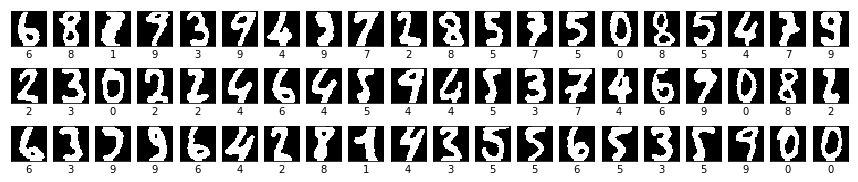

In [4]:
print("Size of dataset: {len} images".format(len=len(images)))

PLOT_SIZE = 60
ROW_WIDTH = 20
plt.figure(figsize=(15, PLOT_SIZE / ROW_WIDTH))
for i in range(PLOT_SIZE):
    plt.subplot(PLOT_SIZE / ROW_WIDTH, ROW_WIDTH, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.xlabel(labels[i])
    plt.imshow(images[i], cmap=plt.cm.binary)

We are also curious how well the digits are distributed:

In [5]:
df = pd.DataFrame(labels, columns=['label'])
df.label.value_counts() / len(df.index)

9    0.106250
7    0.103646
3    0.103646
1    0.103125
6    0.101562
2    0.101562
5    0.097396
4    0.096875
8    0.093750
0    0.092188
Name: label, dtype: float64

Unlike the Yahtzee dataset labels, the distribution of the digits is almost perfect. There are about 10% of every digit in the dataset. Which is pretty equally distributed. This is very good for our deep learning model, because it will prevent bias for a certain label.

#### One-Hot Eencoding

To compare the labels with the predictions of the neural network we need to 'one-hot' encode the labels:

The index of the `1` is the correct label of the data.

In [6]:
def one_hot_encode(labels):
    onehot = np.zeros((len(labels), __LABELS))
    onehot[range(len(labels)), labels] = 1
    return onehot

onehot = one_hot_encode(labels)
print('One hot encoded labels:')
print(onehot[:5])

One hot encoded labels:
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


We combine the data and the labels to be able to shuffle them without forgetting which labels belong to which images.

In [7]:
def get_shuffled_xy(images, onehot):
    data = np.array([np.array([images[i], onehot[i]]) for i in range(len(images))])
    shuffled_data = np.random.permutation(data)
    x = np.array([t[0] for t in shuffled_data])
    x = np.reshape(x, (len(x), 32, 32, 1))
    y = np.array([t[1] for t in shuffled_data])
    return x, y

X, Y = get_shuffled_xy(images, onehot)

print('Images shape: {}'.format(X.shape))
print('Labels shape: {}'.format(Y.shape))

Images shape: (1920, 32, 32, 1)
Labels shape: (1920, 10)


We split the data into train, test, and validation sets.

We use the train set to train; the test set to cross-validate during training; and the validation set to validate the model after the model is done training.

In [8]:
def get_split(x, y, frac):
    split = int(len(x) * frac)
    return x[:split], y[:split], x[split:], y[split:]

X_train, Y_train, X_valid, Y_valid = get_split(X, Y, .85)
X_train, Y_train, X_test, Y_test = get_split(X_train, Y_train, .85)

print('Split X (train, test, validation):', X_train.shape, X_test.shape, X_valid.shape)
print('Split Y (train, test, validation):', Y_train.shape, Y_test.shape, Y_valid.shape)

Split X (train, test, validation): (1387, 32, 32, 1) (245, 32, 32, 1) (288, 32, 32, 1)
Split Y (train, test, validation): (1387, 10) (245, 10) (288, 10)


We define a function that returns a random batch of a certain size. This batch is used in training to train faster.

In [9]:
def get_batch(x, y, size):
    batch = np.array([(x[i], y[i]) for i in range(len(x))])
    random_batch = np.random.permutation(batch)[:size]
    return np.array([x[0] for x in random_batch]), np.array([x[1] for x in random_batch])

We also define a function that does all the above so we can load an arbitrary dataset:

In [10]:
def get_folder_xy(path, extension):
    images, labels = get_images_in_path(path, extension)
    return get_shuffled_xy(images, one_hot_encode(labels))

## Models

We designed several models which were run with an iteration count of 1500 and a batch size of 20

rank | name | layers | optimizer | score
--- | --- | --- | --- | ---
5 | model_1 | Conv2D(f=64, k=3, s=1, act=relu) | Adam | 0.9444444
6 | model_2 | Conv2D(f=64, k=5, act=relu), MaxPool2D(size=2, s=2) | Adam | 0.9166667
4 | model_3 | Conv2D(f=32, k=3, s=1, act=relu), Conv2D(f=64, k=3, s=1, act=relu), MaxPool2D(size=2, s=2), Dropout(0.25), Dense(128, act=relu), Dropout(0.5) | Adam | 0.9444444
2 | model_4 | Conv2D(f=32, k=3, s=1, act=relu), BatchNorm, Conv2D(f=32, k=3, s=1, act=relu), BatchNorm, MaxPool2D(size=2, s=2), Conv2D(f=64, k=3, s=1, act=relu), BatchNorm, Conv2D(f=64, k=3, s=1, act=relu), BatchNorm, Dense(512, act=relu), Dropout(0.2) | Adam | 0.9652778
3 | model_5 | Conv2D(f=32, k=5, s=1, act=relu), Conv2D(f=32, k=5, s=1, act=relu), MaxPool2D(size=2, s=2), Dropout(.25), Conv2D(f=64, k=3, s=1, act=relu), Conv2D(f=64, k=3, s=1, act=relu), MaxPool2D(size=2, s=2), Dropout(.25), Dense(256, act=relu), Dropout(.5) | RMSProp | 0.9513889
1 | model_6 | Conv2D(f=32, k=5, s=1, act=relu, pad=valid), Conv2D(f=32, k=5, s=1, act=relu, pad=valid), BatchNorm, MaxPool2D(size=2, s=1), Dropout(.2), Conv2D(f=64, k=3, s=1, act=relu, pad=same), Conv2D(f=64, k=3, s=1, act=relu, pad=same), BatchNorm, MaxPool2D(size=2, s=1), Dropout(.25), Conv2D(f=128, k=3, s=1, act=relu, pad=same), Dropout(.25), Dense(128), BatchNorm, Dropout(.25) | RMSProp | 0.9826389

- Model 1: BLUE
- Model 2: RED
- Model 3: LIGHT BLUE
- Model 4: PINK
- Model 5: GREEN
- Model 6: GRAY
- Model 7: ORANGE
- Model 8: ORANGE

### Batch Accuracy


### Batch Loss


In [11]:
def model_1(x, output_shape, is_training):
    """
    One Conv2d layer with a kernel size of 3 and 
    """
    conv1 = tf.layers.conv2d(x, filters=32, kernel_size=3, strides=1, padding="same", 
                           activation=tf.nn.relu)
    
    flatten = tf.contrib.layers.flatten(conv1)
    return tf.layers.dense(flatten, units=output_shape, activation=None)

In [12]:
def model_2(x, output_shape, is_training):
    """
    """
    conv1 = tf.layers.conv2d(x, filters=32, kernel_size=5, 
                             padding="same", activation=tf.nn.relu)
    pool1 = tf.layers.max_pooling2d(conv1, pool_size=2, strides=2)
    
    flatten = tf.contrib.layers.flatten(pool1)
    return tf.layers.dense(flatten, units=output_shape, activation=None)

In [13]:
def model_3(x, output_shape, is_training):
    """
    """
    #32 convolution filters used each of size 3x3
    conv1 = tf.layers.conv2d(x, filters=32, kernel_size = 3,
                         strides = 1, padding="same",
                         activation = tf.nn.relu)
    
    #64 convolution filters used each of size 3x3
    conv2 = tf.layers.conv2d(conv1, filters=64, kernel_size = 3,
                         strides = 1, padding="same",
                         activation = tf.nn.relu)
    
    #choose the best features via pooling
    pool1 = tf.layers.max_pooling2d(conv2, pool_size=2, strides=2)
    
    #randomly turn neurons on and off to improve convergence
    dropout1 = tf.layers.dropout(pool1, rate=.25)
    
    #flatten since too many dimensions, we only want a classification output
    flatten = tf.contrib.layers.flatten(dropout1)

    #fully connected to get all relevant data
    dense = tf.layers.dense(flatten, units=128, activation=tf.nn.relu)
    
    #one more dropout for convergence' sake :) 
    dropout2 = tf.layers.dropout(dense, rate=.5)

    return tf.layers.dense(dropout2, units=output_shape, activation=None)

In [14]:
def model_4(x, output_shape, is_training):
    conv1 = tf.layers.conv2d(x, filters=32, kernel_size = 3,
                         strides = 1, padding="same",
                         activation = tf.nn.relu)
    batch_norm1 = tf.layers.batch_normalization(conv1, training=is_training)
    
    conv2 = tf.layers.conv2d(batch_norm1, filters=32, kernel_size = 3,
                         strides = 1, padding="same",
                         activation = tf.nn.relu)
    batch_norm2 = tf.layers.batch_normalization(conv2, training=is_training)
        
    pool1 = tf.layers.max_pooling2d(batch_norm2, pool_size=2, strides=2)

    conv3 = tf.layers.conv2d(pool1, filters=64, kernel_size = 3,
                         strides = 1, padding="same",
                         activation = tf.nn.relu)
    batch_norm3 = tf.layers.batch_normalization(conv3, training=is_training)

    
    conv4 = tf.layers.conv2d(batch_norm3, filters=64, kernel_size = 3,
                         strides = 1, padding="same",
                         activation = tf.nn.relu)
    batch_norm4 = tf.layers.batch_normalization(conv4, training=is_training)

    pool2 = tf.layers.max_pooling2d(batch_norm4, pool_size=2, strides=2)

    flatten = tf.contrib.layers.flatten(pool2)

    # Fully connected layer
    dense = tf.layers.dense(flatten, units=512, activation=tf.nn.relu)

    dropout = tf.layers.dropout(dense, rate=.2)
    
    return tf.layers.dense(dropout, units=output_shape, activation=None)

In [15]:
def model_5(x, output_shape, is_training):
    """
    """
    conv1 = tf.layers.conv2d(x, filters=32, kernel_size = 5,
                         strides = 1, padding="same",
                         activation = tf.nn.relu)
    conv2 = tf.layers.conv2d(conv1, filters=32, kernel_size = 5,
                         strides = 1, padding="same",
                         activation = tf.nn.relu)
    pool1 = tf.layers.max_pooling2d(conv2, pool_size=2, strides=2)
    dropout1 = tf.layers.dropout(pool1, rate=.25)
    
    conv3 = tf.layers.conv2d(x, filters=64, kernel_size = 3,
                         strides = 1, padding="same",
                         activation = tf.nn.relu)
    conv4 = tf.layers.conv2d(conv3, filters=64, kernel_size = 3,
                         strides = 1, padding="same",
                         activation = tf.nn.relu)
    pool2 = tf.layers.max_pooling2d(conv4, pool_size=2, strides=2)
    dropout2 = tf.layers.dropout(pool2, rate=.25)
    
    flatten = tf.contrib.layers.flatten(dropout2)
    dense = tf.layers.dense(flatten, units=256, activation=tf.nn.relu)
    dropout = tf.layers.dropout(dense, rate=.5)

    return tf.layers.dense(dropout, units=output_shape, activation=None)

In [80]:
def model_6(x, output_shape, is_training):
    
    conv1 = tf.layers.conv2d(x, filters=32, kernel_size=5,
                         strides=1, padding="valid",
                         kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False),
                         activation=tf.nn.relu)
    conv2 = tf.layers.conv2d(conv1, filters=32, kernel_size=5,
                         strides=1, padding="valid",
                         kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False),
                         activation=tf.nn.relu)
    batch_norm1 = tf.layers.batch_normalization(conv2, training=is_training)
    
    pool1 = tf.layers.max_pooling2d(batch_norm1, pool_size=2, strides=1)
    dropout1 = tf.layers.dropout(pool1, rate=.2)
    
    conv3 = tf.layers.conv2d(dropout1, filters=64, kernel_size=3,
                         strides=1, padding="same",
                         kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False),
                         activation=tf.nn.relu)
    conv4 = tf.layers.conv2d(conv3, filters=64, kernel_size=3,
                         strides=1, padding="same",
                         kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False),
                         activation=tf.nn.relu)
    batch_norm2 = tf.layers.batch_normalization(conv4, training=is_training)
    
    pool2 = tf.layers.max_pooling2d(batch_norm2, pool_size=2, strides=1)
    dropout2 = tf.layers.dropout(pool2, rate=.25)
    
    conv4 = tf.layers.conv2d(dropout2, filters=128, kernel_size=3,
                         strides=1, padding="same",
                         kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False),
                         activation=tf.nn.relu)
    
    dropout3 = tf.layers.dropout(conv4, rate=.25)
    flatten = tf.contrib.layers.flatten(dropout3)
    dense = tf.layers.dense(flatten, units=128, activation=tf.nn.relu)
    
    batch_norm3 = tf.layers.batch_normalization(dense, training=is_training)
    dropout = tf.layers.dropout(batch_norm3, rate=.25)
    
    return tf.layers.dense(dropout, units=output_shape, activation=None)

We start with the placeholder for our 32x32 pixel input and 10-class output and choose a model:

In [17]:
def setup_model(model):
    tf.reset_default_graph()
    x = tf.placeholder(tf.float32, shape=[None, X_train.shape[1], X_train.shape[2], 1], name='x')
    y = tf.placeholder(tf.float32, shape=[None, Y_train.shape[1]], name='y')
    is_training = tf.placeholder(tf.bool, name='is_training')
    return x, y, is_training, model(x, Y_train.shape[1], is_training)

We choose an optimizer and define a loss functon and the accuracy metric:

In [58]:
def setup_ops(y, y_pred):
    # Loss function
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=y_pred)
    loss_fn = tf.reduce_mean(cross_entropy)

    # Optimizer minimizes the loss
#     optimizer = tf.train.AdamOptimizer(learning_rate=.0003)
    optimizer = tf.train.RMSPropOptimizer(learning_rate=0.001)

    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        train_op = optimizer.minimize(loss_fn)

    # Accuracy metric
    #   checks if the indices of the highest values in the real 
    #   and predicted arrays are equal
    pred_op = tf.argmax(y_pred, axis=1)
    label_op = tf.argmax(y, axis=1)
    correct_op = tf.equal(label_op, pred_op)
    accuracy = tf.reduce_mean(tf.cast(correct_op, tf.float32))
    return loss_fn, train_op, pred_op, label_op, correct_op, accuracy

## Train, Test, Validate

We train the model using a certain batch size and for a number of iterations while posting scalars to TensorBoard:

In [59]:
def train_model(model, data, split_frac=.85, verbose=2, save=False):
    X, Y = data
    x, y, is_training, y_pred = setup_model(model)
    loss_fn, train_op, _, _, _, accuracy = setup_ops(y, y_pred)
    
    iters = (32*50) 
    train_batch_size = 20

    X_train, Y_train, X_valid, Y_valid = get_split(X, Y, split_frac)    
    X_train, Y_train, X_test, Y_test = get_split(X_train, Y_train, split_frac)

    init_op = tf.global_variables_initializer()
    saver = tf.train.Saver()
    session = tf.Session()
    with session:
        session.run(init_op)

        # Defining the metrics we want to log in TensorBoard
        sum_loss_train = tf.summary.scalar('loss_train', loss_fn)
        sum_loss_test = tf.summary.scalar('loss_test', loss_fn)
        sum_acc_train = tf.summary.scalar('acc_train', accuracy)
        sum_acc_test = tf.summary.scalar('acc_test', accuracy)
        tf.summary.merge_all()
        writer = tf.summary.FileWriter(os.path.join(__TENSOR_LOG_DIR, model.__name__), session.graph)

        # Start training for a certain number of iterations
        for i in range(iters):
            # Every iteration we get a random batch of the training data
            x_batch, y_batch = get_batch(X_train, Y_train, train_batch_size)
            # We train the model by providing the 'optimizer' variable to the run function.
            # We also want to calculate the accuracy and loss TensorBoard metrics
            train_op_val, acc_val, sum_1, sum_2 = session.run([train_op, accuracy, 
                                                           sum_loss_train, sum_acc_train], 
                                                           feed_dict={x: x_batch, y: y_batch, is_training: 1})
            # Write the metrics to TensorBoard
            writer.add_summary(sum_1, global_step=i)
            writer.add_summary(sum_2, global_step=i)

            # Validate every 50 iterations
            if i % 50 == 0:
                # DO NOT PROVIDE THE 'optimzer' VARIABLE HERE
                # ELSE THE MODEL WILL TRAIN ON THE TEST DATA
                acc_val, sum_1, sum_2 = session.run([accuracy, sum_loss_test, sum_acc_test], 
                                                    feed_dict={x: X_test, y: Y_test, is_training: 0})
                # Write the metrics to TensorBoard
                writer.add_summary(sum_1, global_step=i)
                writer.add_summary(sum_2, global_step=i)
                if verbose >= 2:
                    print('Validation - i:', i+1, ' Accuracy:', acc_val)


        # Validate the model with unseen data
        acc_ = session.run([accuracy], feed_dict={x: X_valid, y: Y_valid, is_training: 0})
        if verbose >= 1:
            print('Validation accuracy:', acc_)

        # Save the model
        if save:
            path = saver.save(session, '{}.ckpt'.format(os.path.join(__MODEL_PATH, model.__name__, model.__name__)))
            if verbose >= 1:
                print('Model saved at: {}'.format(path))
    
        return acc_
    

In [82]:
train_model(model_6, (X, Y), verbose=2, save=True)

Validation - i: 1  Accuracy: 0.19591837
Validation - i: 51  Accuracy: 0.62857145
Validation - i: 101  Accuracy: 0.8530612
Validation - i: 151  Accuracy: 0.7020408
Validation - i: 201  Accuracy: 0.877551
Validation - i: 251  Accuracy: 0.9142857
Validation - i: 301  Accuracy: 0.955102
Validation - i: 351  Accuracy: 0.9918367
Validation - i: 401  Accuracy: 0.97959185
Validation - i: 451  Accuracy: 0.9755102
Validation - i: 501  Accuracy: 0.9755102
Validation - i: 551  Accuracy: 0.98367345
Validation - i: 601  Accuracy: 0.9918367
Validation - i: 651  Accuracy: 0.9918367
Validation - i: 701  Accuracy: 0.97959185
Validation - i: 751  Accuracy: 0.9877551
Validation - i: 801  Accuracy: 0.98367345
Validation - i: 851  Accuracy: 0.97959185
Validation - i: 901  Accuracy: 0.9877551
Validation - i: 951  Accuracy: 0.9755102
Validation - i: 1001  Accuracy: 0.97959185
Validation - i: 1051  Accuracy: 0.9918367
Validation - i: 1101  Accuracy: 0.9918367
Validation - i: 1151  Accuracy: 0.9918367
Validatio

[0.9722222]

### Cross Validation

We shuffle and train the model multiple times to rule out luck:

In [44]:
def cross_validate_train(model, dir_path, cv=3, split_frac=.85):
    accuracies = []
    for i in range(cv):
        print('{}/{}'.format(i, cv))
        accuracies.append(train_model(model, get_folder_xy(dir_path, ".png"), verbose=0, save=False))
    return cv, np.mean(accuracies)

In [45]:
cv, mean_acc = cross_validate_train(model_6, __DATA_PATH)
print('Cross validation ({}x): {}'.format(cv, mean_acc))

0/3
1/3
2/3
Cross validation (3x): 0.9872685074806213


## Loading a Saved Model

_Note: This requires all cells up to 'Train, Test, Validate' to be executed._

In [ ]:
"""
EDIT THIS TO RUN BEST MODEL
"""
__TEACHER_VALIDATION_PATH = 'dataset-images'
__TEACHER_VALIDATION_EXTENSTION = '.png'

We load the model and the dataset and run just the accuracy metric:

In [ ]:
model_to_load = model_6

load_path = '{}.ckpt'.format(os.path.join(__MODEL_PATH, 
                                          model_to_load.__name__, 
                                          model_to_load.__name__))

X_teacher, Y_teacher = get_folder_xy(__TEACHER_VALIDATION_PATH, __TEACHER_VALIDATION_EXTENSTION)

with tf.Session() as saved_session:
    tf.train.Saver().restore(saved_session, load_path)

    # Validate the model with unseen data
    acc_, correct_, prediction_, label_ = saved_session.run([accuracy, correct, prediction, real_label], 
                                                             feed_dict={x: X_teacher, y: Y_teacher, is_training: 0})
    print('Validation accuracy imported {}: {}'.format(model_to_load.__name__, acc_))

## Conclusion

### Dataset

- The dataset only contains 1920 individual digits. This should be way too less to properly train a neural network.
- The digits in the dataset are almost perfectly distributed; unlike Yahtzee. This prevents the model from learning a bias for more ocurring labels.

### Model

- We could clearly see when a model was overfitting when the validation accuracy was more than 1-2 percent lower than the testing accuracy.
  - When this occured we increased the amount of dropout or we reduced the number of neurons in one ore more layers.

#### Filter sizes
- We created different scenarios for the convolutional layers. For Conv2D we chose to use 32, 64 or 128 filters. We saw that the accuracy increased when using two convolutional layers of the same size before pooling. 

#### Activation Functions
- We tried to change the activation function of our best model (6). We changed it from ReLu to Tanh, but this didn't seem to help. Our accuracy dropped from 97,6% to 93,4%.

#### Optimizers
- At first, we used the Adam optimizers for optimizing our neural networks, but after searching for other neural networks on the internet we saw that they were using the RMSProp optimizer. We tried it out on our models and model 5 and 6 saw an increase in accuracy of 1%. 

#### Kernels & Strides
- We used two different kernel sizes for our convolutional layers. We used 3x3 and 5x5. We first created model 6 with the first 2 convolutional layers with a kernel size of 3x3. The score was 97,6%, but when we used a 5x5 kernel size on the first 2 conv layers the accuracy hit 98,3%! We think that there is a relation between the convolutional filters and the kernel size. A bigger kernel size on less filters and a smaller kernel size on a bigger filter should retrieve higher percentages. 

#### Batch Normalization
- With Batch Normalization we saw a decrease in accuracy of 1,5% when we removed it from model 6. It makes a big difference.